## TP3 Regresión lineal
Basado en Bishop's PRML. Chapter 3 [https://www.di.fc.ul.pt/~jpn/r/PRML/chapter3.html](https://www.di.fc.ul.pt/~jpn/r/PRML/chapter3.html)  

In [11]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Carga de datos con verificación
- Entrada: vector $x \in \mathbb{R}^5$ (5 características)
- Salida: vector $t \in \mathbb{R}^5$ (5 targets distintos)
- Ejemplos: 100 pares $(x, t)$

In [12]:
X_all = np.loadtxt("datasets/dataset-4-training-Entradas.txt")
t_all = np.loadtxt("datasets/dataset-4-training-targets.txt")
X_unknown = np.loadtxt("datasets/dataset-4-Entradas.txt")

N = X_all.shape[0]
D = X_all.shape[1]
D_out = t_all.shape[1] if t_all.ndim > 1 else 1

# Asegurar que t_all sea 2D
if t_all.ndim == 1:
    t_all = t_all.reshape(-1, 1)

# Separar en entrenamiento y validación
# El dataset tiene N ejemplos, dividir 80% en entrenamiento y 20% en validación
n_train = int(0.8 * N)
X_train, X_val = X_all[:n_train], X_all[n_train:]
t_train, t_val = t_all[:n_train], t_all[n_train:]

print(f"\nDatos totales: {N}")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")
print(f"Shape t_train: {t_train.shape}")
print(f"Shape t_val: {t_val.shape}")


Datos totales: 100
Shape X_train: (80, 5)
Shape X_val: (20, 5)
Shape t_train: (80, 5)
Shape t_val: (20, 5)


### 2. Funciones de base

In [13]:
class PolyBasis:
    """Clase para transformación polinómica"""
    def __init__(self, degree):
        self.degree = degree
        self.X_mean = None
        self.X_std = None
    
    def fit(self, X):
        """Calcula parámetros de normalización"""
        self.X_mean = np.mean(X, axis=0, keepdims=True)
        self.X_std = np.std(X, axis=0, keepdims=True) + 1e-8
        return self
    
    def transform(self, X):
        """Aplica la transformación polinómica"""
        N = X.shape[0]
        Phi = [np.ones((N, 1))]
        
        # Normalizar con los parámetros guardados
        X_norm = (X - self.X_mean) / self.X_std
        
        for p in range(1, self.degree + 1):
            Phi.append(X_norm ** p)
        
        result = np.hstack(Phi)
        
        # Verificar resultado
        if np.isnan(result).any() or np.isinf(result).any():
            print(f"WARNING: Phi contiene NaN o Inf en transform!")
            print(f"  X_norm stats: mean={np.mean(X_norm):.3f}, std={np.std(X_norm):.3f}")
            print(f"  Degree: {self.degree}")
        
        return result
    
    def fit_transform(self, X):
        """Ajusta y transforma en un solo paso"""
        return self.fit(X).transform(X)


class RBFBasis:
    """Clase para transformación RBF"""
    def __init__(self, M, sigma=None):
        self.M = M
        self.sigma = sigma
        self.centers = None
    
    def fit(self, X):
        """Selecciona centros y calcula sigma"""
        # Elegir centros
        idx = np.random.choice(len(X), min(self.M, len(X)), replace=False)
        self.centers = X[idx]
        
        # Calcular sigma si no fue provisto
        if self.sigma is None:
            if self.M > 1:
                dists = []
                for i in range(self.M):
                    for j in range(i + 1, self.M):
                        dist = np.sqrt(np.sum((self.centers[i] - self.centers[j])**2))
                        dists.append(dist)
                self.sigma = max(np.mean(dists), 0.1) if len(dists) > 0 else 1.0
            else:
                self.sigma = 1.0
        
        return self
    
    def transform(self, X):
        """Aplica la transformación RBF"""
        N = X.shape[0]
        Phi = np.ones((N, 1 + self.M))
        
        for j in range(self.M):
            diff = X - self.centers[j]
            sq_dist = np.sum(diff**2, axis=1)
            Phi[:, j + 1] = np.exp(-sq_dist / (2 * self.sigma**2))
        
        return Phi
    
    def fit_transform(self, X):
        """Ajusta y transforma en un solo paso"""
        return self.fit(X).transform(X)

### 3. Estimación de pesos

In [14]:
def solve_weights(Phi, t, lam=1e-1):
    """Resuelve el sistema de ecuaciones lineales para obtener los pesos con regularización y verificación"""
    M = Phi.shape[1]
    
    # Verificar que Phi no tenga NaN
    if np.isnan(Phi).any() or np.isinf(Phi).any():
        print("ERROR: Phi contiene NaN o Inf antes de resolver")
        print(f"  Phi shape: {Phi.shape}")
        print(f"  NaN count: {np.isnan(Phi).sum()}")
        print(f"  Inf count: {np.isinf(Phi).sum()}")
        return np.zeros((M, t.shape[1]))
    
    A = Phi.T @ Phi + lam * np.eye(M)
    b = Phi.T @ t
    
    try:
        w = np.linalg.solve(A, b)
        
        # Verificar resultado
        if np.isnan(w).any() or np.isinf(w).any():
            print("WARNING: w contiene NaN o Inf, usando lstsq")
            w = np.linalg.lstsq(Phi, t, rcond=None)[0]
        
        return w
    except np.linalg.LinAlgError:
        print("ERROR: Matriz singular, usando lstsq")
        return np.linalg.lstsq(Phi, t, rcond=None)[0]


def mse(y, t):
    """MSE con verificación"""
    if np.isnan(y).any():
        print(f"WARNING: y contiene {np.isnan(y).sum()} NaN values")
    if np.isnan(t).any():
        print(f"WARNING: t contiene {np.isnan(t).sum()} NaN values")
    
    error = (y - t) ** 2
    valid_errors = error[~np.isnan(error)]
    
    if len(valid_errors) == 0:
        return np.nan
    
    return np.mean(valid_errors)

### 4. Experimentar con bases polinómicas


=== Probando bases polinómicas ===

Probando grado 1...
  Phi_train shape: (80, 6)
  Phi_train tiene NaN: False
  y_train tiene NaN: False
  Phi_val shape: (20, 6)
  Phi_val tiene NaN: False
  y_val tiene NaN: False
  Train MSE: 646249.292071, Val MSE: 545823.549812

Probando grado 2...
  Phi_train shape: (80, 11)
  Phi_train tiene NaN: False
  y_train tiene NaN: False
  Phi_val shape: (20, 11)
  Phi_val tiene NaN: False
  y_val tiene NaN: False
  Train MSE: 571427.051333, Val MSE: 477562.272742

Probando grado 3...
  Phi_train shape: (80, 16)
  Phi_train tiene NaN: False
  y_train tiene NaN: False
  Phi_val shape: (20, 16)
  Phi_val tiene NaN: False
  y_val tiene NaN: False
  Train MSE: 533879.041908, Val MSE: 526859.057530

Probando grado 4...
  Phi_train shape: (80, 21)
  Phi_train tiene NaN: False
  y_train tiene NaN: False
  Phi_val shape: (20, 21)
  Phi_val tiene NaN: False
  y_val tiene NaN: False
  Train MSE: 500212.103255, Val MSE: 598392.632229

Probando grado 5...
  Phi_tra

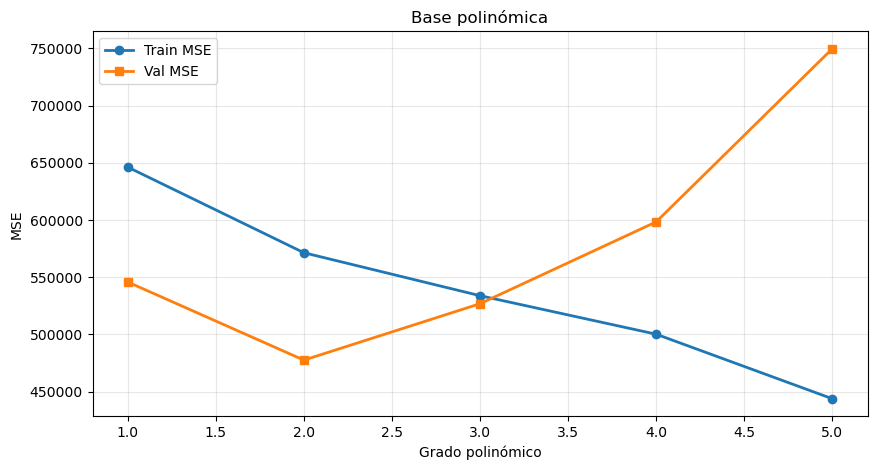

In [15]:
print("\n=== Probando bases polinómicas ===")
degrees = [1, 2, 3, 4, 5]
train_mse_poly, val_mse_poly = [], []

for deg in degrees:
    print(f"\nProbando grado {deg}...")
    
    # Crear y ajustar la base con datos de entrenamiento
    poly_basis = PolyBasis(deg)
    Phi_train = poly_basis.fit_transform(X_train)
    
    print(f"  Phi_train shape: {Phi_train.shape}")
    print(f"  Phi_train tiene NaN: {np.isnan(Phi_train).any()}")
    
    w = solve_weights(Phi_train, t_train, lam=1e-3)
    
    # Predicciones en train
    y_train = Phi_train @ w
    print(f"  y_train tiene NaN: {np.isnan(y_train).any()}")
    
    # Transformar validación con los MISMOS parámetros
    Phi_val = poly_basis.transform(X_val)
    print(f"  Phi_val shape: {Phi_val.shape}")
    print(f"  Phi_val tiene NaN: {np.isnan(Phi_val).any()}")
    
    y_val = Phi_val @ w
    print(f"  y_val tiene NaN: {np.isnan(y_val).any()}")
    
    # Errores
    mse_train = mse(y_train, t_train)
    mse_val = mse(y_val, t_val)
    
    train_mse_poly.append(mse_train)
    val_mse_poly.append(mse_val)
    
    print(f"  Train MSE: {mse_train:.6f}, Val MSE: {mse_val:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(degrees, train_mse_poly, 'o-', label="Train MSE", linewidth=2)
plt.plot(degrees, val_mse_poly, 's-', label="Val MSE", linewidth=2)
plt.xlabel("Grado polinómico")
plt.ylabel("MSE")
plt.legend()
plt.title("Base polinómica")
plt.grid(True, alpha=0.3)
plt.show()

### 5. Experimentar con RBFs


=== Probando bases RBF ===

Probando M=2 RBFs...
  Sigma: 155.2270
  Phi_train shape: (80, 3)
  Train MSE: 669186.155232, Val MSE: 522079.111130

Probando M=5 RBFs...
  Sigma: 151.2811
  Phi_train shape: (80, 6)
  Train MSE: 630755.477104, Val MSE: 505701.438166

Probando M=10 RBFs...
  Sigma: 142.8592
  Phi_train shape: (80, 11)
  Train MSE: 591801.171910, Val MSE: 488105.613400

Probando M=20 RBFs...
  Sigma: 149.6686
  Phi_train shape: (80, 21)
  Train MSE: 511265.073756, Val MSE: 501250.020542

Probando M=50 RBFs...
  Sigma: 150.6100
  Phi_train shape: (80, 51)
  Train MSE: 411012.700184, Val MSE: 550210.144293


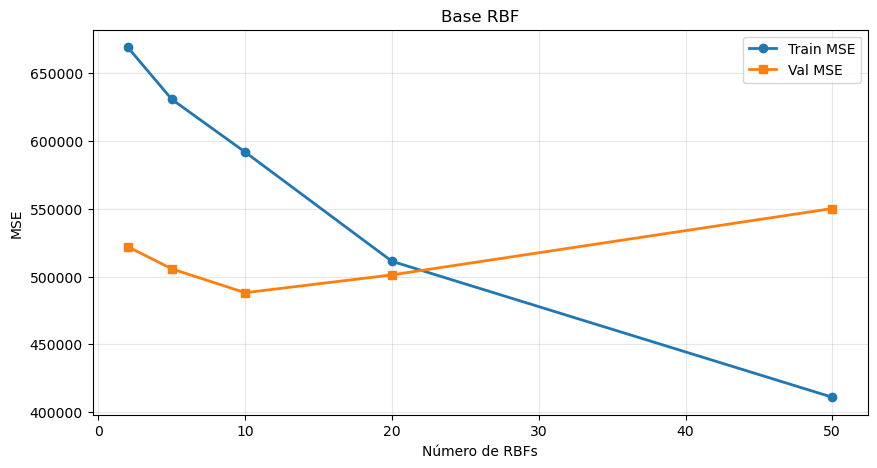

In [16]:
print("\n=== Probando bases RBF ===")
M_list = [2, 5, 10, 20, 50]
train_mse_rbf, val_mse_rbf = [], []

# Fijar semilla para reproducibilidad
np.random.seed(42)

for M in M_list:
    print(f"\nProbando M={M} RBFs...")
    
    # Crear y ajustar la base
    rbf_basis = RBFBasis(M)
    Phi_train = rbf_basis.fit_transform(X_train)
    
    print(f"  Sigma: {rbf_basis.sigma:.4f}")
    print(f"  Phi_train shape: {Phi_train.shape}")
    
    w = solve_weights(Phi_train, t_train, lam=1e-3)
    
    # Predicciones
    y_train = Phi_train @ w
    Phi_val = rbf_basis.transform(X_val)
    y_val = Phi_val @ w
    
    # Errores
    mse_train = mse(y_train, t_train)
    mse_val = mse(y_val, t_val)
    
    train_mse_rbf.append(mse_train)
    val_mse_rbf.append(mse_val)
    
    print(f"  Train MSE: {mse_train:.6f}, Val MSE: {mse_val:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(M_list, train_mse_rbf, 'o-', label="Train MSE", linewidth=2)
plt.plot(M_list, val_mse_rbf, 's-', label="Val MSE", linewidth=2)
plt.xlabel("Número de RBFs")
plt.ylabel("MSE")
plt.legend()
plt.title("Base RBF")
plt.grid(True, alpha=0.3)
plt.show()

### 6. Elegir el mejor modelo


=== Selección del mejor modelo ===
Mejor polinomio: grado 2, MSE val = 477562.272742
Mejor RBF: M=10, MSE val = 488105.613400

Modelo elegido: Polinomial grado 2

=== Entrenamiento final ===
Predicciones guardadas en predicciones_unknown.txt

=== Distribución predictiva ===
Varianza del ruido estimada: [462303.88507215 557973.00759092 576231.35563235 525175.72635905
 590828.76569478]


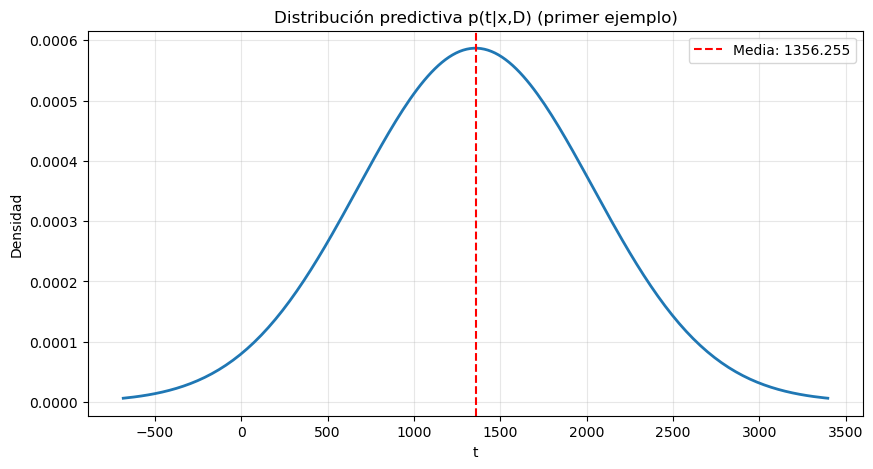

In [17]:
print("\n=== Selección del mejor modelo ===")
best_poly_deg = degrees[np.argmin(val_mse_poly)]
best_rbf_M = M_list[np.argmin(val_mse_rbf)]

print(f"Mejor polinomio: grado {best_poly_deg}, MSE val = {min(val_mse_poly):.6f}")
print(f"Mejor RBF: M={best_rbf_M}, MSE val = {min(val_mse_rbf):.6f}")

# Elegir entre polinomio y RBF
if min(val_mse_poly) <= min(val_mse_rbf):
    chosen = ("poly", best_poly_deg)
    print(f"\nModelo elegido: Polinomial grado {best_poly_deg}")
else:
    chosen = ("rbf", best_rbf_M)
    print(f"\nModelo elegido: RBF con M={best_rbf_M}")

# 7. Entrenamiento final y predicción
print("\n=== Entrenamiento final ===")
np.random.seed(42)

if chosen[0] == "poly":
    basis = PolyBasis(chosen[1])
    Phi_all = basis.fit_transform(X_all)
    w_final = solve_weights(Phi_all, t_all, lam=1e-3)
    Phi_unknown = basis.transform(X_unknown)
else:
    basis = RBFBasis(chosen[1])
    Phi_all = basis.fit_transform(X_all)
    w_final = solve_weights(Phi_all, t_all, lam=1e-3)
    Phi_unknown = basis.transform(X_unknown)

# Predicciones
y_unknown = Phi_unknown @ w_final
np.savetxt("predicciones_unknown.txt", y_unknown, fmt="%.6f")
print("Predicciones guardadas en predicciones_unknown.txt")

# 8. Distribución predictiva
print("\n=== Distribución predictiva ===")
residuals = t_all - (Phi_all @ w_final)
sigma2 = np.var(residuals, axis=0)

print(f"Varianza del ruido estimada: {sigma2}")

# Graficar distribución predictiva para la primera salida
idx = 0
mu = y_unknown[idx, 0]
var = sigma2[0] if sigma2.size > 1 else sigma2

if var > 0 and not np.isnan(var):
    xs = np.linspace(mu - 3*np.sqrt(var), mu + 3*np.sqrt(var), 200)
    pdf = 1/np.sqrt(2*np.pi*var) * np.exp(-0.5*((xs-mu)**2)/var)
    
    plt.figure(figsize=(10, 5))
    plt.plot(xs, pdf, linewidth=2)
    plt.axvline(mu, color='r', linestyle='--', label=f'Media: {mu:.3f}')
    plt.title("Distribución predictiva p(t|x,D) (primer ejemplo)")
    plt.xlabel("t")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("WARNING: Varianza inválida, no se puede graficar la distribución")

### Verificación de homocedasticidad

=== Análisis de heterocedasticidad (100 ejemplos completos) ===



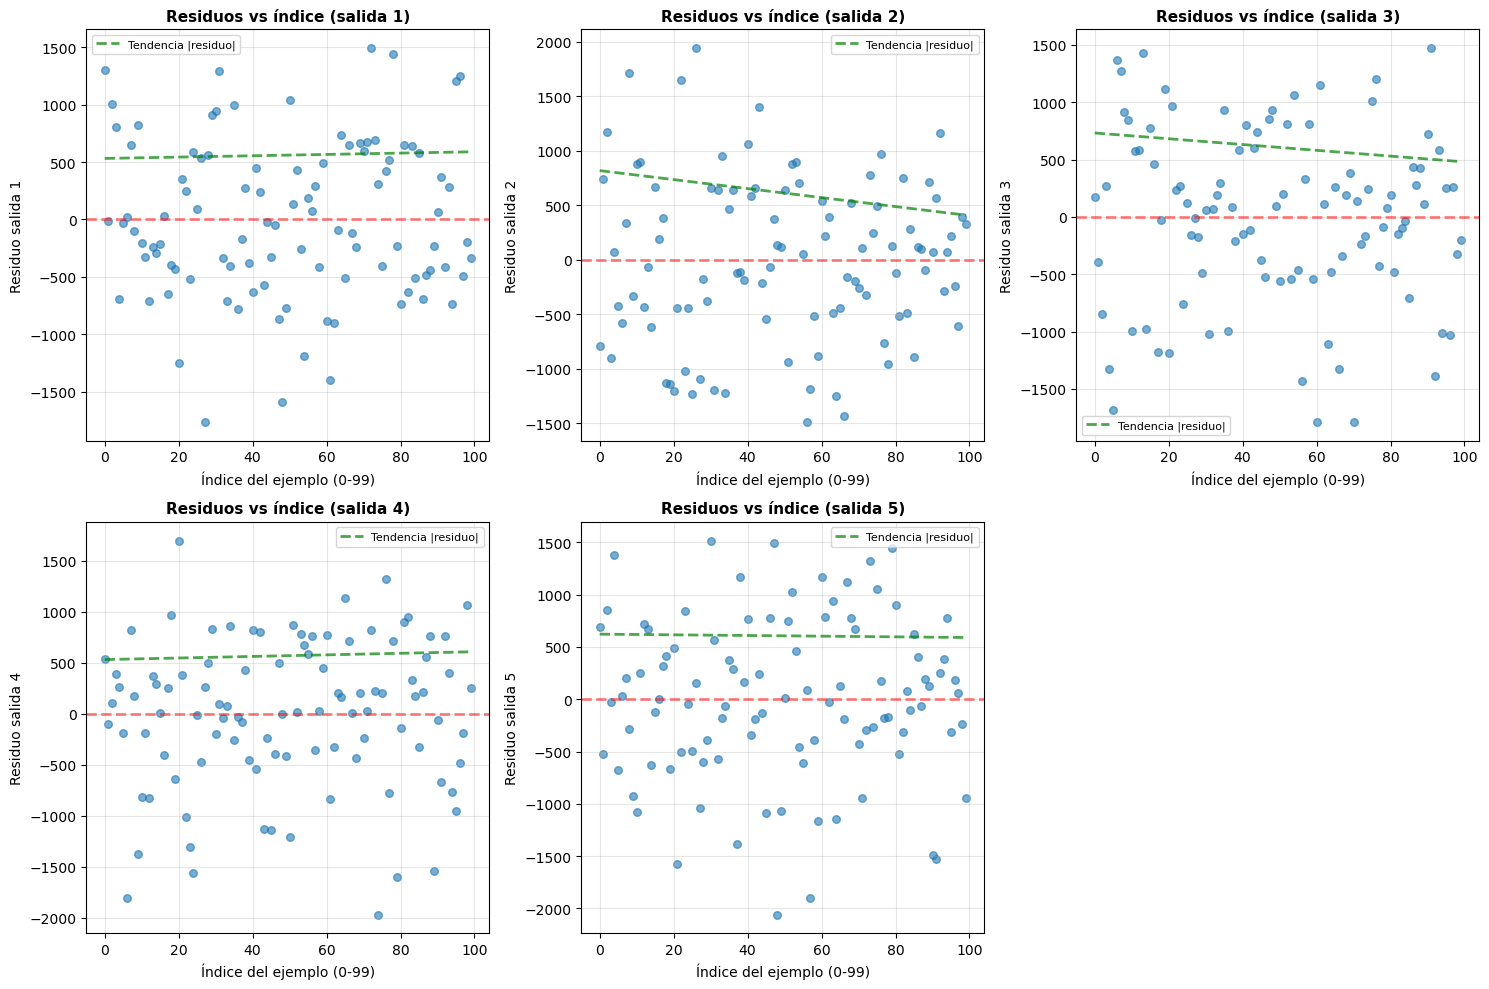

Varianza de residuos por ventanas:

Salida 1:
  Ejemplos [  0- 20]: varianza = 326907.9418
  Ejemplos [ 20- 40]: varianza = 605330.1414
  Ejemplos [ 40- 60]: varianza = 384795.8755
  Ejemplos [ 60- 80]: varianza = 553898.8433
  Ejemplos [ 80-100]: varianza = 381068.5381
  → Ratio máx/mín: 1.85
  ✓  Varianza relativamente constante

Salida 2:
  Ejemplos [  0- 20]: varianza = 616952.2111
  Ejemplos [ 20- 40]: varianza = 870951.0536
  Ejemplos [ 40- 60]: varianza = 613918.2150
  Ejemplos [ 60- 80]: varianza = 411928.0524
  Ejemplos [ 80-100]: varianza = 244430.5511
  → Ratio máx/mín: 3.56
  ⚠️  ALERTA: Posible heterocedasticidad (ratio > 2)

Salida 3:
  Ejemplos [  0- 20]: varianza = 922564.3062
  Ejemplos [ 20- 40]: varianza = 336605.4623
  Ejemplos [ 40- 60]: varianza = 452008.7126
  Ejemplos [ 60- 80]: varianza = 685124.4316
  Ejemplos [ 80-100]: varianza = 427895.8079
  → Ratio máx/mín: 2.74
  ⚠️  ALERTA: Posible heterocedasticidad (ratio > 2)

Salida 4:
  Ejemplos [  0- 20]: varianza

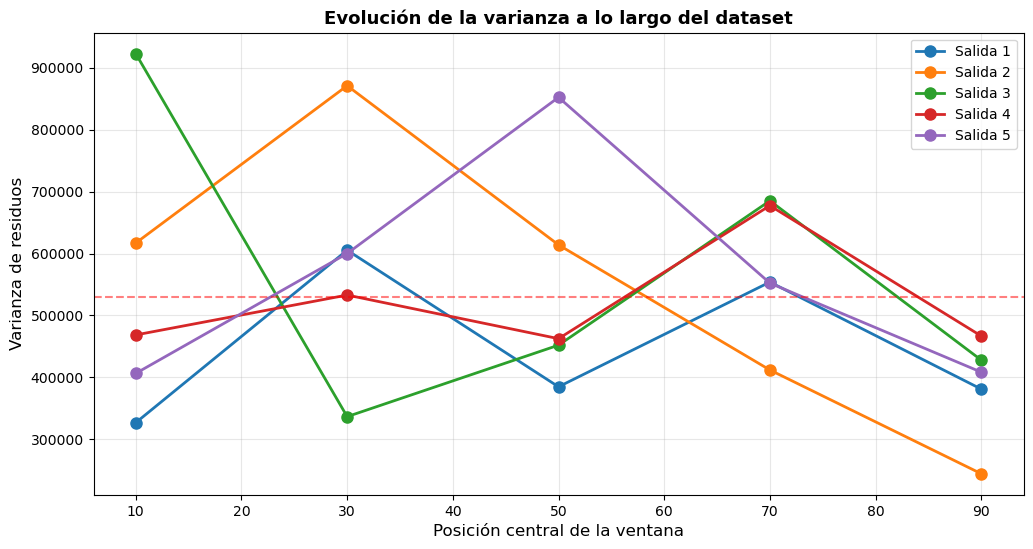


=== Test de heterocedasticidad (Breusch-Pagan simplificado) ===

Salida 1:
  Correlación(índice, residuo²) = -0.0020
  ✓  Correlación baja → Varianza constante

Salida 2:
  Correlación(índice, residuo²) = -0.2592
  ✓  Correlación baja → Varianza constante

Salida 3:
  Correlación(índice, residuo²) = -0.1319
  ✓  Correlación baja → Varianza constante

Salida 4:
  Correlación(índice, residuo²) = 0.0120
  ✓  Correlación baja → Varianza constante

Salida 5:
  Correlación(índice, residuo²) = 0.0118
  ✓  Correlación baja → Varianza constante

=== Resumen estadístico de residuos ===

Salida 1:
  Media: -0.0084
  Std Dev: 679.9293
  Min: -1764.7202
  Max: 1492.8793

Salida 2:
  Media: -0.0036
  Std Dev: 746.9759
  Min: -1488.7219
  Max: 1940.3920

Salida 3:
  Media: -0.0059
  Std Dev: 759.0990
  Min: -1788.2182
  Max: 1471.8201

Salida 4:
  Media: -0.0047
  Std Dev: 724.6901
  Min: -1966.0860
  Max: 1696.8570

Salida 5:
  Media: -0.0050
  Std Dev: 768.6539
  Min: -2059.0988
  Max: 1518.2603



In [18]:
# Usar el modelo ya entrenado (RBF M=2 en tu caso)
# Asumiendo que ya tienes: Phi_all, w_final, t_all

# Calcular residuos en TODOS los 100 ejemplos
residuals = t_all - (Phi_all @ w_final)

print("=== Análisis de heterocedasticidad (100 ejemplos completos) ===\n")

# Graficar residuos vs índice para cada salida
plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.scatter(range(len(residuals)), residuals[:, i], alpha=0.6, s=30)
    plt.axhline(0, color='r', linestyle='--', alpha=0.5, linewidth=2)
    
    # Línea de tendencia de la desviación absoluta
    abs_residuals = np.abs(residuals[:, i])
    z = np.polyfit(range(len(residuals)), abs_residuals, 1)
    p = np.poly1d(z)
    plt.plot(range(len(residuals)), p(range(len(residuals))), 
             "g--", alpha=0.7, linewidth=2, label='Tendencia |residuo|')
    
    plt.xlabel('Índice del ejemplo (0-99)', fontsize=10)
    plt.ylabel(f'Residuo salida {i+1}', fontsize=10)
    plt.title(f'Residuos vs índice (salida {i+1})', fontsize=11, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Calcular varianza por ventanas en los 100 ejemplos
window_size = 20
print("Varianza de residuos por ventanas:\n")

variance_table = []
for i in range(5):
    print(f"Salida {i+1}:")
    variances = []
    for start in range(0, 100, window_size):
        end = min(start + window_size, 100)
        var_window = np.var(residuals[start:end, i])
        variances.append(var_window)
        print(f"  Ejemplos [{start:3d}-{end:3d}]: varianza = {var_window:.4f}")
    
    # Calcular ratio max/min
    ratio = max(variances) / min(variances)
    print(f"  → Ratio máx/mín: {ratio:.2f}")
    
    # Test estadístico: ¿la varianza cambia significativamente?
    if ratio > 2.0:
        print(f"  ⚠️  ALERTA: Posible heterocedasticidad (ratio > 2)")
    else:
        print(f"  ✓  Varianza relativamente constante")
    print()
    
    variance_table.append(variances)

# Visualizar la evolución de varianzas
plt.figure(figsize=(12, 6))
window_centers = [start + window_size//2 for start in range(0, 100, window_size)]

for i in range(5):
    plt.plot(window_centers, variance_table[i], 'o-', 
             label=f'Salida {i+1}', linewidth=2, markersize=8)

plt.xlabel('Posición central de la ventana', fontsize=12)
plt.ylabel('Varianza de residuos', fontsize=12)
plt.title('Evolución de la varianza a lo largo del dataset', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(np.mean([item for sublist in variance_table for item in sublist]), 
            color='red', linestyle='--', alpha=0.5, label='Media global')
plt.show()

# Test de Breusch-Pagan simplificado
print("\n=== Test de heterocedasticidad (Breusch-Pagan simplificado) ===\n")

for i in range(5):
    # Correlación entre índice y residuo al cuadrado
    squared_residuals = residuals[:, i]**2
    indices = np.arange(len(residuals))
    
    correlation = np.corrcoef(indices, squared_residuals)[0, 1]
    
    print(f"Salida {i+1}:")
    print(f"  Correlación(índice, residuo²) = {correlation:.4f}")
    
    if abs(correlation) > 0.3:
        print(f"  ⚠️  Correlación significativa → Posible heterocedasticidad")
    else:
        print(f"  ✓  Correlación baja → Varianza constante")
    print()

# Resumen estadístico
print("=== Resumen estadístico de residuos ===\n")
for i in range(5):
    print(f"Salida {i+1}:")
    print(f"  Media: {np.mean(residuals[:, i]):.4f}")
    print(f"  Std Dev: {np.std(residuals[:, i]):.4f}")
    print(f"  Min: {np.min(residuals[:, i]):.4f}")
    print(f"  Max: {np.max(residuals[:, i]):.4f}")
    print()

Se observa que la varianza de los residuos es constante para todas las salidas.